<a href="https://colab.research.google.com/github/EiffL/N5K/blob/master/notebooks/N5K_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/EiffL/N5K.git
%cd N5K

Cloning into 'N5K'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 199 (delta 88), reused 151 (delta 52), pack-reused 0
Receiving objects: 100% (199/199), 9.45 MiB | 12.34 MiB/s, done.
Resolving deltas: 100% (88/88), done.
/content/N5K


In [ ]:
!pip install pybind11 pyccl
!pip install -e .

     |████████████████████████████████| 12.0MB 12.4MB/s 
  ERROR: Failed building wheel for pyccl
  Running setup.py clean for pyccl
Failed to build pyccl
    Running setup.py install for pyccl ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-dukbwj58/pyccl/setup.py'"'"'; __file__='"'"'/tmp/pip-install-dukbwj58/pyccl/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-zl5pj7gt/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.
Obtaining file:///content/N5K
  Found existing installation: N5K 0.0.1
    Can't uninstall 'N5K'. No files were found to uninstall.
  Running setup.py develop for N5K


In [ ]:
%pylab inline
from n5k.calculator_base import N5KCalculatorBase

Populating the interactive namespace from numpy and matplotlib


In [ ]:
calc = N5KCalculatorBase('tests/config.yml')

In [ ]:
pk = calc.get_pk()
kernels = calc.get_tracer_kernels()
background = calc.get_background()

In [ ]:
[i for i in pk.keys()]

['k', 'z', 'pk_nl', 'pk_lin']

In [ ]:
[i for i in kernels.keys()]

['z_cl', 'chi_cl', 'kernels_cl', 'z_sh', 'chi_sh', 'kernels_sh']

In [ ]:
[i for i in background.keys()]

['z', 'chi', 'Ez']

In [ ]:
# Create conversion table from z to chi
from scipy.interpolate import interp1d, interp2d
chi2z = interp1d(background['chi'], background['z'])
z2chi = interp1d(background['z'], background['chi'])
# Create power spectrum interpolator in k and chi
pk_interp = interp2d(pk['k'], z2chi(pk['z']), pk['pk_nl'])
# Create window interpolator
kernel_interp = interp1d(kernels['chi_sh'], kernels['kernels_sh'][0], 
                      fill_value=0., bounds_error=False )

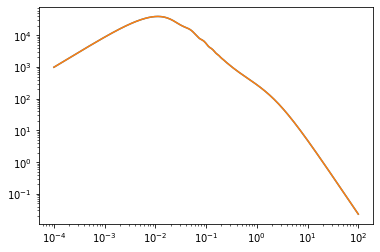

In [ ]:
loglog(pk['k'],pk['pk_nl'][10])
loglog(pk['k'],pk_interp(pk['k'], z2chi(pk['z'][10])))

## OK, time to implement some bessel transforms

The idea is that we can compute
$$C_l = \int_k k^2 \int_{r_1} w(r_1) \sqrt{(P(k, r_1))} j_l(k r_1) dr_1 \int_{r_2} w(r_2)  \sqrt{(P(k, r_2))} j_l(k r_2) d r_2 $$

Each of the inner integrals can be computed by discrete spherical bessel transform because $w(r)$ goes to zero at some point. We can solve both on a grid
of k values, and then compute the integral maybe with a spline or smthg.

The additional cool trick I have up my sleeve is that we only need to do this for l=0 if I remember correctly, we can compute all other transforms at other ells using a correction factor.



So all we need to do, is to implement a jax version of the DSBT :-D 9 years after its inception!


In [ ]:
import jax.numpy as jnp
from scipy.special import spherical_jn
from bessel_tools import bessel_zeros

In [ ]:
q0 = (np.arange(1000)+1)*pi

In [ ]:
# For a given range of k 
k = pk['k']
# For a given l
l = 10
# Let's compute the corresponding rln
kmax = k[-1]

In [ ]:
# Nmax at l=0, this is conservative
nmax = int(kernels['chi_sh'][-1] * kmax / pi)

In [ ]:
# Compute the bessel zeros that correspond to these requirements
qln = bessel_zeros(l, nmax)

In [ ]:
# From which we derive rln
rln = qln[10] / kmax
rmax = rln[-1]

In [ ]:
# So, now, we can compute the transform 
def transform(k):
  integrand = kernel_interp(rln) * np.sqrt(pk_interp(k, rln))
  return 1. / kmax**3 integrand.dot(  np.sqrt(2*pi) / spherical_jn(l+1, qln[l])**2 *spherical_jn(l, rln * k))

In [ ]:
integrand = (kernel_interp(rln) * np.sqrt(pk_interp(k, rln)).T)

In [ ]:
transformed = 1. / kmax**3 * integrand * (  np.sqrt(2*pi) / spherical_jn(l+1, qln[l])**2 * spherical_jn(l, np.outer(rln, k)).T)

In [ ]:
transformed = transformed.sum(axis=1)

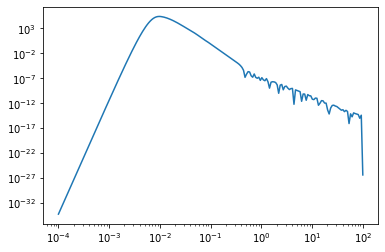

In [ ]:
loglog(k, transformed**2*k**2)

In [ ]:
from scipy.integrate import simps

In [ ]:
simps(transformed[:100]**2*k[:100]**2, k[:100])

1648.1366007572651

In [ ]:
k[100]

0.10353218432956615

In [ ]:
def transform(l, k):

  
  # Compute the transform matrix
  T = np.einsum('')

In [ ]:
class DiscreteSphericalBesselTransform:
  """
  Class for computing a DSBT, based on method proposed in 
  Lanusse et al. 2011
  """
  def __init__(self, rmax, kmax, lmax=10):
    """ Initializes a new transform

    Parameters
    ----------
      chimax: float
        Maximum non-zero radial value
      kmax: float
        Maximum non-zero scale
    """
    # Rough estimate of the number of bessel zeros we will need for this
    # transform
    bess_zeros = bessel_zeros(0, 10000)
    # Nmax so that qlNmax = kmax * rmax
    nmax = where(bess_zeros[0] > kmax * rmax)[0][0]
    self.rmax = rmax
    self.kmax = kmax
    self.nmax = nmax
    # We can now compute the bessel zeros that will be needed for the
    # transform
    self.qln = bessel_zeros(lmax, nmax)
    # And, we can precompute the transformation matrix at l=0
    self.T = (2 * pi) / spherical_jn(1, q[0])**2 *spherical_jn(0, np.einsum('j,k->jk', q[0],q[0]) / q[0,-1])
def discrete_spherical_bessel_transform():
  """

  """


In [ ]:
# Step I: compute transform of l=0
# in this case, the qlns are simply equispaced by pi
q0 = (np.arange(1000)+1)*pi

In [ ]:
rmax = kernels['chi_sh'][-1]
kmax = q0.max() / rmax

In [ ]:
# Step II: compute the transform matrix and corresponding r_ln grid
T0 = (2 * pi) / spherical_jn(1, q0)**2 *spherical_jn(0, np.einsum('j,k->jk', q0, q0) / q0[-1])
r0 = q0/kmax
k0 = q0/rmax

In [ ]:
# Step III: get the integrand function
from scipy.interpolate import interp1d
integrand = interp1d(kernels['chi_sh'], kernels['kernels_sh'][0] / kernels['chi_sh']**2 , 
                      fill_value=0., bounds_error=False )

In [ ]:
# DSBT transformed of integrand
transformed = 1/kmax**3 * T0.dot(integrand(r0))

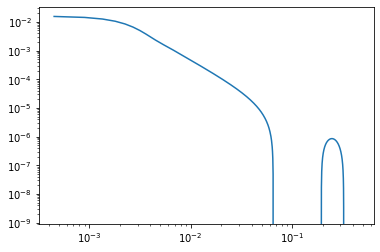

In [ ]:
# And here is the result
loglog(k0, transformed)

In [ ]:
def transform(k, r,  )
pk['k'][-1]

100.0

In [ ]:
bess_zeros = bessel_zeros(2, 10000)

In [ ]:
chimax = kernels['chi_sh'][-1]
kmax = pk['k'][-1]/100
nmax = where(bess_zeros[1] > kmax * chimax)[0][0]

In [ ]:
#plot(kernels['chi_sh'], kernels['kernels_cl'][-1])
plot(kernels['chi_sh'], kernels['kernels_sh'][0])

In [ ]:
q = bessel_zeros(100, nmax)

In [ ]:
q.shape

(101, 2213)

In [ ]:
T = (np.einsum('ij,ik->ijk', q[:-1],q[:-1]).T / q[:-1,-1]).T

In [ ]:
T00 = np.sqrt(2 * pi) / spherical_jn(1, q[0])**2 * spherical_jn(0, T[0])

In [ ]:
rln = q[0] / kmax
kln = q[0] / chimax

In [ ]:
# So, now, we can compute the transform
from scipy.interpolate import interp1d

In [ ]:
kernel_rln = interp1d(kernels['chi_sh'], 
                      kernels['kernels_sh'][0], 
                      fill_value=0., bounds_error=False )(rln)

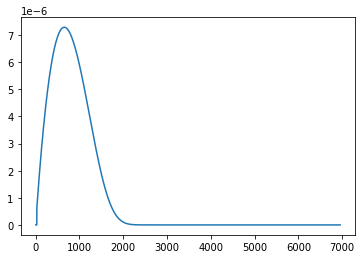

In [ ]:
plot(rln, kernel_rln)

In [ ]:
transformed = T00.dot(kernel_rln)

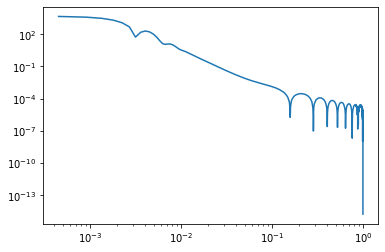

In [ ]:
loglog(kln, abs(transformed))

In [ ]:
rec = T00.dot(transformed)

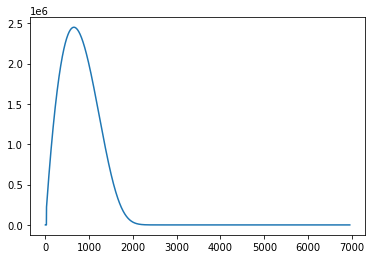

In [ ]:
plot(rln, rec)
